# Import Packages

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda
import torchvision.datasets as dsets
from torchsummary import summary
from torch.autograd import Variable
from tqdm import tqdm_notebook
import torchvision
import torch.nn.functional as F
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, confusion_matrix
from torchvision import datasets, transforms, ops
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle 
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline

# Select Mode of Running: True(Train Model)  False(Read Pretrained Model)

In [2]:
Train_Mlp = True
Train_Cnn = True
Train_Cnn_DropBlock = True
Train_Cnn_KernelFactor = True

# (A) : Loading Dataset

In [3]:
dataset = datasets.ImageFolder('dataset/Shoe vs Sandal vs Boot Dataset',
                               transform = transforms.Compose([
                               transforms.Resize((120, 160)),
                               transforms.ToTensor()]))

train_dataset, test_dataset = torch.utils.data.random_split(dataset,(int(len(dataset) * 0.7), len(dataset) - int(len(dataset) * 0.7)))

# (A) : Showing Some Samples From Dataset

Shape of the images: torch.Size([3, 120, 160])


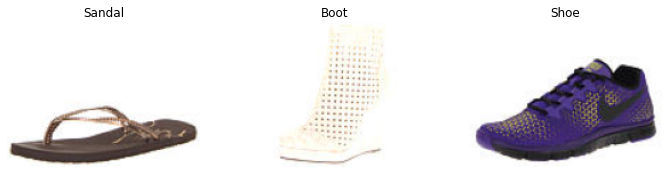

In [4]:
print(f"Shape of the images: {train_dataset[0][0].shape}")

Class_Name = { 0: "Boot", 1: "Sandal", 2: "Shoe"}
figure = plt.figure(figsize=(20, 20))
k = 0
label_list = []
while len(label_list) != 3:
    index = random.randint(0, len(train_dataset)-1)
    img, label = train_dataset[index]
#     label = torch.argmax(label).item()
    if label not in label_list:
        k += 1
        label_list.append(label)
        figure.add_subplot(4, 5, k)
        plt.title(Class_Name[label])
        plt.axis("off")
        plt.imshow(transforms.ToPILImage()(img))  
    
plt.show()

# (A) : Making Dataset Iterable

In [5]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size*2, 
                                          shuffle=False)


# (B) : Define Train & Test Loop For Mlp Model

In [47]:
def train_loop(dataloader, model, loss_fn, optimizer, log):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        
        pred = model(X.to(torch.float32).to(device))
        loss = loss_fn(pred, y.to(device))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()
            
    train_loss /= num_batches
    train_acc /= size
    
    log['train_loss'].append(train_loss)
    log['train_acc'].append(train_acc)
    
    print(f"Train Result: \n Accuracy: {(100*train_acc):>0.1f}%, Avg Train loss: {train_loss:>8f} \n")

def test_loop(dataloader, model, loss_fn, log):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc, test_loss_min = 0, 0, np.Inf 
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(torch.float32).to(device))
            loss = loss_fn(pred, y.to(device))
            
            test_loss += loss.item()
            test_acc += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    test_loss /= num_batches
    test_acc /= size
    
    if(log!=None):
        
        log['test_loss'].append(test_loss)
        log['test_acc'].append(test_acc)
        
        if(test_loss <= min(log['test_loss'])):
            torch.save(model.state_dict(), './model/best_mlp_model.pt')
            print('Model Saved')    

    print(f"Test Result: \n Accuracy: {(100*test_acc):>0.1f}%, Avg Test loss: {test_loss:>8f} \n")        

# (B) : Create Mlp Model Class

In [48]:
class Mlp_Class(nn.Module):
    def __init__(self):
        super(Mlp_Class, self).__init__()
        
        self.mpl = nn.Sequential(
            nn.Linear(3*120*160, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 3)
        )
        
        self.flat = nn.Flatten()

    def forward(self, x):
        x = self.flat(x)
        logits = self.mpl(x)
        return logits

# (B) : Calculate Number of Mlp Parameters 

In [49]:
mlp_model = Mlp_Class()

trainable_param_number = sum(p.numel() for p in mlp_model.parameters() if p.requires_grad)

print(f"Trainable Param Number Is : {trainable_param_number:,}")

Trainable Param Number Is : 60,559,363


# (B) : Define Hyper Parameters & Optimizer & Loss Function

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
mlp_model = mlp_model.to(device)

criterion = nn.CrossEntropyLoss()

lr_sgd = 1e-3
epochs = 10
optimizer_sgd = torch.optim.SGD(mlp_model.parameters(), lr=lr_sgd, momentum=0.9)

# (B) : Training Process Of Mlp Model

In [51]:
if(Train_Mlp):
    
    log = {'train_loss':[], 'test_loss' : [], 'train_acc' : [], 'test_acc' : []}
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        mlp_model.train()
        train_loop(train_loader, mlp_model, criterion, optimizer_sgd, log = log)
        mlp_model.eval()
        test_loop(test_loader, mlp_model, criterion, log = log)
        
    print("Done!")
    
    with open('best_mlp_result.pkl', 'wb') as f:
        pickle.dump(log, f)   
else:
    
    mlp_model.load_state_dict(torch.load('./model/best_mlp_model.pt'))  
    with open('best_mlp_result.pkl', 'rb') as f:
        log = pickle.load(f)
    print('Model Loaded')
    mlp_model.eval()
    test_loop(test_loader, mlp_model, criterion, log = None)

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 75.2%, Avg Train loss: 0.600592 

Model Saved
Test Result: 
 Accuracy: 85.8%, Avg Test loss: 0.392052 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 83.9%, Avg Train loss: 0.407843 

Model Saved
Test Result: 
 Accuracy: 85.8%, Avg Test loss: 0.373604 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 85.6%, Avg Train loss: 0.374930 

Model Saved
Test Result: 
 Accuracy: 86.9%, Avg Test loss: 0.342076 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 86.5%, Avg Train loss: 0.341177 

Model Saved
Test Result: 
 Accuracy: 89.3%, Avg Test loss: 0.291808 

Epoch 5
-------------------------------
Train Result: 
 Accuracy: 88.6%, Avg Train loss: 0.303665 

Test Result: 
 Accuracy: 88.9%, Avg Test loss: 0.304013 

Epoch 6
-------------------------------
Train Result: 
 Accuracy: 89.1%, Avg Train loss: 0.284712 

Test Result: 
 Accuracy: 86.4%, Avg Test loss: 0.337011 

Epoc

# (B) : Plot The Result Of Mlp Model

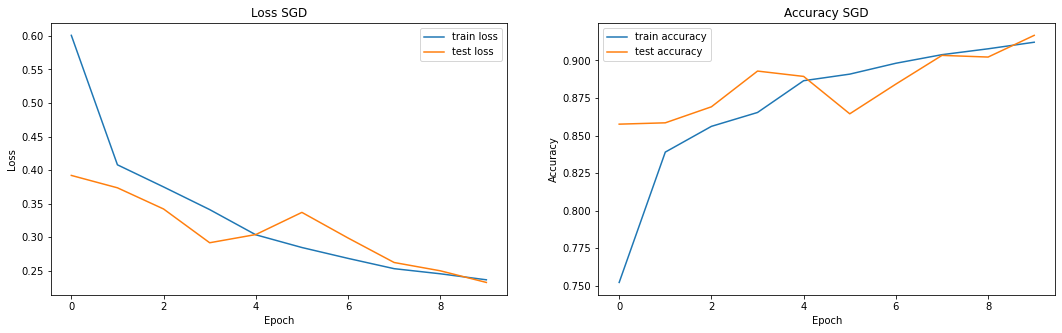

In [52]:
n_epochs = [*range(epochs)]
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(n_epochs, log['train_loss'])
plt.plot(n_epochs, log['test_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss SGD')
plt.legend(['train loss', 'test loss'])
plt.subplot(122)
plt.plot(n_epochs, log['train_acc'])
plt.plot(n_epochs, log['test_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy SGD')
plt.legend(['train accuracy', 'test accuracy'])

# (B) : Evaluate Mlp Model Based On Different Metrics

In [53]:
def EvaluateModel(dataloader, model, loss_fn):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, test_acc = 0, 0
    y_pred_list = []
    y_true_list = []
    
    with torch.no_grad():
        for X, y in dataloader:
            
            pred = model(X.to(torch.float32).to(device))
            loss = loss_fn(pred, y.to(device))
            
            y_pred_list.extend(pred.argmax(1).cpu().numpy())
            y_true_list.extend(y.numpy())
            
            test_loss += loss.item()
            
    test_loss /= num_batches
    
    return y_pred_list, y_true_list, test_loss 

# (B) : Conclusion

              precision    recall  f1-score   support

        Boot       0.95      0.94      0.94      1482
      Sandal       0.93      0.86      0.89      1512
        Shoe       0.88      0.95      0.91      1506

    accuracy                           0.92      4500
   macro avg       0.92      0.92      0.92      4500
weighted avg       0.92      0.92      0.92      4500

Accuracy Test : 0.9166666666666666
Loss Test : 0.23270703065143505
Precision Score Micro Test : 0.9166666666666666
Precision Score Macro Test : 0.9180475052487719
Recall Score Micro Test : 0.9166666666666666
Recall Score Macro Test : 0.9168659352834932
Trainable Param Number Is : 60,559,363


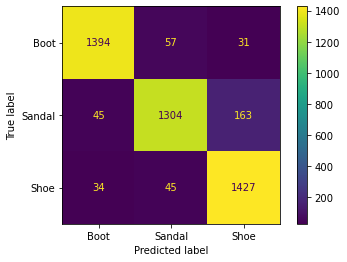

In [54]:
mlp_model.eval()
y_pred, y_true, test_loss = EvaluateModel(test_loader, mlp_model, criterion)
target_names = ["Boot", "Sandal", "Shoe"]

acc = accuracy_score(y_true, y_pred)
recall_micro = recall_score(y_true, y_pred, average = 'micro')
recall_macro = recall_score(y_true, y_pred, average = 'macro')
precision_micro = precision_score(y_true, y_pred, average='micro')
precision_macro = precision_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=target_names))
print(f'Accuracy Test : {accuracy_score(y_true, y_pred)}')
print(f'Loss Test : {test_loss}')
print(f'Precision Score Micro Test : {precision_micro}')
print(f'Precision Score Macro Test : {precision_macro}')
print(f'Recall Score Micro Test : {recall_micro}')
print(f'Recall Score Macro Test : {recall_macro}')

cf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=target_names)
disp.plot()

trainable_param_number = sum(p.numel() for p in mlp_model.parameters() if p.requires_grad)

print(f"Trainable Param Number Is : {trainable_param_number:,}")

# (C) : Plot Loss & Accuracy Of MLP Model On Tensorboard

In [55]:
writer = SummaryWriter()

for n_iter in n_epochs:
    writer.add_scalar('Loss/train', log['train_loss'][n_iter], n_iter)
    writer.add_scalar('Loss/test', log['test_loss'][n_iter],n_iter)
    writer.add_scalar('Accuracy/train', log['train_acc'][n_iter], n_iter)
    writer.add_scalar('Accuracy/test', log['test_acc'][n_iter], n_iter)
    
writer.close()

In [56]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.11.0 at http://localhost:6007/ (Press CTRL+C to quit)
^C


# (D) : Create CNN Model Class

In [57]:
class CNN_Class(nn.Module):
    def __init__(self):
        super(CNN_Class,self).__init__()
        
        self.conv_layer = nn.Sequential(
            
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*27*37, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 3),
        )
        
        self.drop = nn.Dropout(0.2)
        self.flatten = nn.Flatten()
        
        
    def forward(self,inputs):
        
        x = self.conv_layer(inputs)  # conv layers
        x = self.drop(x)     # Dropout
        x = self.flatten(x)   # Flatten
        x = self.fc_layer(x)     
        return(x)

# (D) : Calculate Number of CNN Parameter 

In [70]:
cnn_model = CNN_Class()

trainable_param_number = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)

print(f"Trainable Param Number Is : {trainable_param_number:,}")

Trainable Param Number Is : 32,797,955


# (D) : Define Hyper Parameters & Optimizer & Loss Function

In [71]:
device = "cuda" if torch.cuda.is_available() else "cpu"
cnn_model = cnn_model.to(device)

criterion = nn.CrossEntropyLoss()

lr_sgd = 1e-3
epochs = 10
optimizer_sgd = torch.optim.SGD(cnn_model.parameters(), lr=lr_sgd, momentum=0.9)

# (D) : Define Train & Test Loop On CNN Model

In [72]:
def train_loop(dataloader, model, loss_fn, optimizer, log):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        
        pred = model(X.to(torch.float32).to(device))
        loss = loss_fn(pred, y.to(device))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()
            
    train_loss /= num_batches
    train_acc /= size
    
    log['train_loss'].append(train_loss)
    log['train_acc'].append(train_acc)
    
    print(f"Train Result: \n Accuracy: {(100*train_acc):>0.1f}%, Avg Train loss: {train_loss:>8f} \n")

def test_loop(dataloader, model, loss_fn, log):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc, test_loss_min = 0, 0, np.Inf 
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(torch.float32).to(device))
            loss = loss_fn(pred, y.to(device))
            
            test_loss += loss.item()
            test_acc += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    test_loss /= num_batches
    test_acc /= size
    
    if(log!=None):
        
        log['test_loss'].append(test_loss)
        log['test_acc'].append(test_acc)
        
        if(test_loss <= min(log['test_loss'])):
            torch.save(model.state_dict(), './model/best_cnn_model.pt')
            print('Model Saved')    

    print(f"Test Result: \n Accuracy: {(100*test_acc):>0.1f}%, Avg Test loss: {test_loss:>8f} \n")   

# (D) : Training Process Of CNN Model

In [73]:
if(Train_Cnn):
    
    log = {'train_loss':[], 'test_loss' : [], 'train_acc' : [], 'test_acc' : []}
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        cnn_model.train()
        train_loop(train_loader, cnn_model, criterion, optimizer_sgd, log = log)
        cnn_model.eval()
        test_loop(test_loader, cnn_model, criterion, log = log)
        
    print("Done!")
    
    with open('best_cnn_result.pkl', 'wb') as f:
        pickle.dump(log, f)   
else:
    
    cnn_model.load_state_dict(torch.load('./model/best_cnn_model.pt'))  
    with open('best_cnn_result.pkl', 'rb') as f:
        log = pickle.load(f)
    print('Model Loaded')
    cnn_model.eval()
    test_loop(test_loader, cnn_model, criterion, log = None)

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 88.4%, Avg Train loss: 0.315842 

Model Saved
Test Result: 
 Accuracy: 93.6%, Avg Test loss: 0.179357 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 94.9%, Avg Train loss: 0.139666 

Model Saved
Test Result: 
 Accuracy: 95.0%, Avg Test loss: 0.131773 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 96.8%, Avg Train loss: 0.096578 

Model Saved
Test Result: 
 Accuracy: 95.6%, Avg Test loss: 0.127341 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 97.7%, Avg Train loss: 0.068596 

Model Saved
Test Result: 
 Accuracy: 96.0%, Avg Test loss: 0.113652 

Epoch 5
-------------------------------
Train Result: 
 Accuracy: 98.6%, Avg Train loss: 0.041689 

Model Saved
Test Result: 
 Accuracy: 97.1%, Avg Test loss: 0.085994 

Epoch 6
-------------------------------
Train Result: 
 Accuracy: 99.3%, Avg Train loss: 0.024558 

Test Result: 
 Accuracy: 96.6%, Avg Test loss: 0.0

# (D) : Plot The Result Of CNN Model

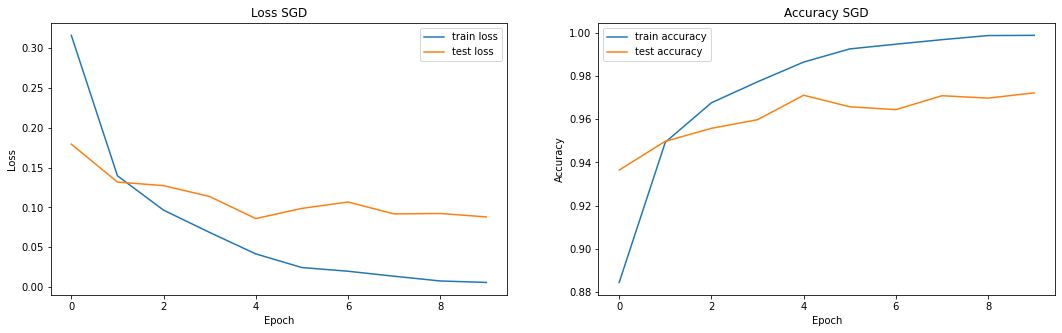

In [74]:
n_epochs = [*range(epochs)]
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(n_epochs, log['train_loss'])
plt.plot(n_epochs, log['test_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss SGD')
plt.legend(['train loss', 'test loss'])
plt.subplot(122)
plt.plot(n_epochs, log['train_acc'])
plt.plot(n_epochs, log['test_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy SGD')
plt.legend(['train accuracy', 'test accuracy'])

# (D) : Evaluate CNN Model Based On Different Metrics

In [75]:
def EvaluateModel(dataloader, model, loss_fn):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, test_acc = 0, 0
    y_pred_list = []
    y_true_list = []
    
    with torch.no_grad():
        for X, y in dataloader:
            
            pred = model(X.to(torch.float32).to(device))
            loss = loss_fn(pred, y.to(device))
            
            y_pred_list.extend(pred.argmax(1).cpu().numpy())
            y_true_list.extend(y.numpy())
            
            test_loss += loss.item()
            
    test_loss /= num_batches
    
    return y_pred_list, y_true_list, test_loss 

# (D) : Conclusion

              precision    recall  f1-score   support

        Boot       0.98      0.98      0.98      1482
      Sandal       0.97      0.96      0.97      1512
        Shoe       0.96      0.97      0.97      1506

    accuracy                           0.97      4500
   macro avg       0.97      0.97      0.97      4500
weighted avg       0.97      0.97      0.97      4500

Accuracy Test : 0.9722222222222222
Loss Test : 0.0880784622990382
Precision Score Micro Test : 0.9722222222222222
Precision Score Macro Test : 0.9722757898918047
Recall Score Micro Test : 0.9722222222222222
Recall Score Macro Test : 0.9722880038372455
Trainable Param Number Is : 32,797,955


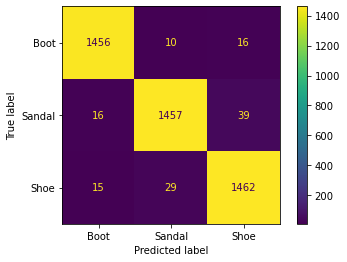

In [76]:
cnn_model.eval()
y_pred, y_true, test_loss = EvaluateModel(test_loader, cnn_model, criterion)
target_names = ["Boot", "Sandal", "Shoe"]

acc = accuracy_score(y_true, y_pred)
recall_micro = recall_score(y_true, y_pred, average = 'micro')
recall_macro = recall_score(y_true, y_pred, average = 'macro')
precision_micro = precision_score(y_true, y_pred, average='micro')
precision_macro = precision_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=target_names))
print(f'Accuracy Test : {accuracy_score(y_true, y_pred)}')
print(f'Loss Test : {test_loss}')
print(f'Precision Score Micro Test : {precision_micro}')
print(f'Precision Score Macro Test : {precision_macro}')
print(f'Recall Score Micro Test : {recall_micro}')
print(f'Recall Score Macro Test : {recall_macro}')

cf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=target_names)
disp.plot()
trainable_param_number = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)

print(f"Trainable Param Number Is : {trainable_param_number:,}")

# (C) : Plot Loss & Accuracy Of CNN Model

In [77]:
writer = SummaryWriter()

for n_iter in n_epochs:
    writer.add_scalar('Loss/train', log['train_loss'][n_iter], n_iter)
    writer.add_scalar('Loss/test', log['test_loss'][n_iter],n_iter)
    writer.add_scalar('Accuracy/train', log['train_acc'][n_iter], n_iter)
    writer.add_scalar('Accuracy/test', log['test_acc'][n_iter], n_iter)
    
writer.close()

In [78]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.11.0 at http://localhost:6008/ (Press CTRL+C to quit)
^C


# (E) : **Compare MLP & CNN**

* MLP ------->   **Accuracy Test** : 0.916 ---- **Loss Test** : 0.232 ---- **Trainable Param Number Is** : 60,559,363
* CNN ------->   **Accuracy Test** : 0.972 ---- **Loss Test** : 0.088 ---- **Trainable Param Number Is** : 32,797,955
* By Comparing Cnn and Mlp we notice that CNN network has fewer parameters than MLP but get lower loss and higher accuracy and it means it works better than mlp model

# (F) : **Create DropBlock Class**

* **Dropout** is widely used as a regularization technique for fully connected layers and less effective at regularizing convolutional layers since convolutional layers have few parameters, they need less regularization to begin with. Furthermore, because of the spatial relationships encoded in feature maps, activations can become highly correlated. This renders dropout ineffective.



* **DropBlock** is a structured form of dropout directed at regularizing convolutional networks. 


* In **DropBlock**, units in a contiguous region of a feature map are dropped together. As DropBlock discards features in a correlated area, the networks must look elsewhere for evidence to fit the data.



* **DropBlock** method was introduced to combat the major drawback of Dropout being dropping features randomly which prove to be effective strategy for fully connected networks but less fruitful when it comes to convolutional layers wherein features are spatially correlated. DropBlock technique discards features in a contiguous correlated area called block. By doing so, it is able to fulfill the purpose of generating simpler model and to put in the concept of learning a fraction of the weights in the network in each training iteration to penalize the weight matrix which in turn reduces overfitting.

In [107]:
class DropBlock2D(nn.Module):
    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)

# (F) : Create CNN Model Based On DropBlock

In [108]:
drop_block = DropBlock2D(block_size=3, drop_prob=0.2)
class CNNDropBlock(nn.Module):
    def __init__(self):
        super(CNNDropBlock,self).__init__()
        
        self.conv_layer = nn.Sequential(
            
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(76800, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 3),
        )
        
        self.drop = nn.Dropout(0.2)
        self.flatten = nn.Flatten()
        
        
    def forward(self,inputs):
        
        x = self.conv_layer(inputs)  # conv layers
        x = drop_block(x)     # Dropout
        x = self.flatten(x)   # Flatten
        x = self.fc_layer(x)     
        return(x)

# (F) : Calculate Number of CNN Based On DropBlock Parameters 

In [109]:
cnn_dropblock_model = CNNDropBlock()

trainable_param_number = sum(p.numel() for p in cnn_dropblock_model.parameters() if p.requires_grad)

print(f"Trainable Param Number Is : {trainable_param_number:,}")

Trainable Param Number Is : 39,384,323


# (F) : Define Hyper Parameters & Optimizer & Loss Function

In [110]:
device = "cuda" if torch.cuda.is_available() else "cpu"
cnn_dropblock_model = cnn_dropblock_model.to(device)

criterion = nn.CrossEntropyLoss()

lr_sgd = 1e-3
epochs = 10
optimizer_sgd = torch.optim.SGD(cnn_dropblock_model.parameters(), lr=lr_sgd, momentum=0.9)

# (F) : Define Train & Test Loop On CNN Based On DropBlock

In [111]:
def train_loop(dataloader, model, loss_fn, optimizer, log):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        
        pred = model(X.to(torch.float32).to(device))
        loss = loss_fn(pred, y.to(device))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()
            
    train_loss /= num_batches
    train_acc /= size
    
    log['train_loss'].append(train_loss)
    log['train_acc'].append(train_acc)
    
    print(f"Train Result: \n Accuracy: {(100*train_acc):>0.1f}%, Avg Train loss: {train_loss:>8f} \n")

def test_loop(dataloader, model, loss_fn, log):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc, test_loss_min = 0, 0, np.Inf 
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(torch.float32).to(device))
            loss = loss_fn(pred, y.to(device))
            
            test_loss += loss.item()
            test_acc += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    test_loss /= num_batches
    test_acc /= size
    
    if(log!=None):
        
        log['test_loss'].append(test_loss)
        log['test_acc'].append(test_acc)
        
        if(test_loss <= min(log['test_loss'])):
            torch.save(model.state_dict(), './model/best_cnn_dropblock_model.pt')
            print('Model Saved')    

    print(f"Test Result: \n Accuracy: {(100*test_acc):>0.1f}%, Avg Test loss: {test_loss:>8f} \n") 

# (F) : Training Process On CNN Based On DropBlock

In [112]:
if(Train_Cnn_DropBlock):
    
    log = {'train_loss':[], 'test_loss' : [], 'train_acc' : [], 'test_acc' : []}
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        cnn_dropblock_model.train()
        train_loop(train_loader, cnn_dropblock_model, criterion, optimizer_sgd, log = log)
        cnn_dropblock_model.eval()
        test_loop(test_loader, cnn_dropblock_model, criterion, log = log)
        
    print("Done!")
    
    with open('best_cnn_dropblock_result.pkl', 'wb') as f:
        pickle.dump(log, f)   
else:
    
    cnn_dropblock_model.load_state_dict(torch.load('./model/best_cnn_dropblock_model.pt'))  
    with open('best_cnn_dropblock_result.pkl', 'rb') as f:
        log = pickle.load(f)
    print('Model Loaded')
    cnn_dropblock_model.eval()
    test_loop(test_loader, cnn_dropblock_model, criterion, log = None)

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 86.5%, Avg Train loss: 0.352475 

Model Saved
Test Result: 
 Accuracy: 89.0%, Avg Test loss: 0.287094 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 93.3%, Avg Train loss: 0.188759 

Model Saved
Test Result: 
 Accuracy: 91.9%, Avg Test loss: 0.209818 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 95.8%, Avg Train loss: 0.120956 

Model Saved
Test Result: 
 Accuracy: 95.3%, Avg Test loss: 0.125996 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 97.1%, Avg Train loss: 0.087772 

Test Result: 
 Accuracy: 94.9%, Avg Test loss: 0.140819 

Epoch 5
-------------------------------
Train Result: 
 Accuracy: 97.8%, Avg Train loss: 0.065054 

Model Saved
Test Result: 
 Accuracy: 96.5%, Avg Test loss: 0.101667 

Epoch 6
-------------------------------
Train Result: 
 Accuracy: 98.6%, Avg Train loss: 0.043351 

Model Saved
Test Result: 
 Accuracy: 96.6%, Avg Test loss: 0.0

# (F) : **Conclusion**
* As you can see, using drop block increase the accuracy from 97.2% to 97.6%  and decrease the average loss from  0.088078 to 0.085359 and it works very well on cnn based model

# (G) : Create CNN Model Based On Kernel Factorization

In [113]:
class CNN_KernelFactor(nn.Module):
    def __init__(self):
        super(CNN_KernelFactor,self).__init__()
        
        self.conv_layer = nn.Sequential(
            
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1,3), groups=16),
            
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,3), groups=32),
            
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1,3), groups=64),
            
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1,3), groups=64),
            
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*27*37, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 3),
        )
        
        self.drop = nn.Dropout(0.2)
        self.flatten = nn.Flatten()
        
        
    def forward(self,inputs):
        
        x = self.conv_layer(inputs)  # conv layers
        x = self.drop(x)      # Dropout   
        x = self.flatten(x)   # Flatten
        x = self.fc_layer(x)     
        return(x)

# (G) : Calculate Number of CNN Parameter Based On Kernel Factorization

In [114]:
cnn_kernelfactor_model = CNN_KernelFactor()

trainable_param_number = sum(p.numel() for p in cnn_kernelfactor_model.parameters() if p.requires_grad)

print(f"Trainable Param Number Is : {trainable_param_number:,}")

Trainable Param Number Is : 32,758,435


# (G) : Define Hyper Parameter & Optimizer & Loss Function

In [115]:
device = "cuda" if torch.cuda.is_available() else "cpu"
cnn_kernelfactor_model = cnn_kernelfactor_model.to(device)

criterion = nn.CrossEntropyLoss()

lr_sgd = 1e-3
epochs = 10
optimizer_sgd = torch.optim.SGD(cnn_kernelfactor_model.parameters(), lr=lr_sgd, momentum=0.9)

# (G) : Define Train & Test Loop On CNN Based On Kernel Factorization

In [116]:
def train_loop(dataloader, model, loss_fn, optimizer, log):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        
        pred = model(X.to(torch.float32).to(device))
        loss = loss_fn(pred, y.to(device))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()
            
    train_loss /= num_batches
    train_acc /= size
    
    log['train_loss'].append(train_loss)
    log['train_acc'].append(train_acc)
    
    print(f"Train Result: \n Accuracy: {(100*train_acc):>0.1f}%, Avg Train loss: {train_loss:>8f} \n")

def test_loop(dataloader, model, loss_fn, log):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc, test_loss_min = 0, 0, np.Inf 
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(torch.float32).to(device))
            loss = loss_fn(pred, y.to(device))
            
            test_loss += loss.item()
            test_acc += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    test_loss /= num_batches
    test_acc /= size
    
    if(log!=None):
        
        log['test_loss'].append(test_loss)
        log['test_acc'].append(test_acc)
        
        if(test_loss <= min(log['test_loss'])):
            torch.save(model.state_dict(), './model/best_cnn_kernelfactor_model.pt')
            print('Model Saved')    

    print(f"Test Result: \n Accuracy: {(100*test_acc):>0.1f}%, Avg Test loss: {test_loss:>8f} \n") 

# (G) : Training Process On CNN Based On Kernel Factorization

In [117]:
if(Train_Cnn_KernelFactor):
    
    log = {'train_loss':[], 'test_loss' : [], 'train_acc' : [], 'test_acc' : []}
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        cnn_kernelfactor_model.train()
        train_loop(train_loader, cnn_kernelfactor_model, criterion, optimizer_sgd, log = log)
        cnn_kernelfactor_model.eval()
        test_loop(test_loader, cnn_kernelfactor_model, criterion, log = log)
        
    print("Done!")
    
    with open('best_cnn_kernelfactor_result.pkl', 'wb') as f:
        pickle.dump(log, f)   
else:
    
    cnn_kernelfactor_model.load_state_dict(torch.load('./model/best_cnn_kernelfactor_model.pt'))  
    with open('best_cnn_kernelfactor_result.pkl', 'rb') as f:
        log = pickle.load(f)
    print('Model Loaded')
    cnn_kernelfactor_model.eval()
    test_loop(test_loader, cnn_kernelfactor_model, criterion, log = None)

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 83.6%, Avg Train loss: 0.410407 

Model Saved
Test Result: 
 Accuracy: 90.0%, Avg Test loss: 0.257091 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 93.4%, Avg Train loss: 0.184899 

Model Saved
Test Result: 
 Accuracy: 94.2%, Avg Test loss: 0.157925 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 95.2%, Avg Train loss: 0.139810 

Model Saved
Test Result: 
 Accuracy: 94.8%, Avg Test loss: 0.144555 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 96.4%, Avg Train loss: 0.102072 

Model Saved
Test Result: 
 Accuracy: 95.2%, Avg Test loss: 0.127338 

Epoch 5
-------------------------------
Train Result: 
 Accuracy: 97.1%, Avg Train loss: 0.081390 

Test Result: 
 Accuracy: 94.6%, Avg Test loss: 0.146035 

Epoch 6
-------------------------------
Train Result: 
 Accuracy: 97.6%, Avg Train loss: 0.072388 

Model Saved
Test Result: 
 Accuracy: 96.6%, Avg Test loss: 0.1

# (G) : **Compare With & Without Kernel Factorization**

* With Kernel Factorization ------->   **Accuracy Test** : 97.4 ---- **Loss Test** : 0.094 ---- **Trainable Param Number Is** : 32,758,435
* Without Kernel Factorization  ------->   **Accuracy Test** : 97.2 ---- **Loss Test** : 0.088 ---- **Trainable Param Number Is** : 60,559,363
* When we use kernel factorization **the number of parameter decreased** but using **nonlinear activation** function such as relu help it to works even better than cnn without kernel factorization.